# Multivariate Time-Series Forecasting: Predict Iron Prices

### Import libs

In [9]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
from pylab import rcParams


from sklearn.preprocessing import StandardScaler

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam



## ||||||||||||||||||||||||||||||| Part 1: Data preprocessing |||||||||||||||||||||||||||||||

###  Read and load the data; we want to select the features for the training and prediction and extract the date column then make it the index

Index & Date columns...

check for null values:

In [2]:
# import training dataset
dataset_train= pd.read_excel(r'C:\Users\fnafisa\WORKSPACE\professional\Project PoC\Input\data\Construction materials\segregated\حديد تسليح 12مم وطني.xlsx')
dataset_train.columns = ['date','price', 'oil_brent', 'tasi', 'gold', 'interest_rate', 'historical']
dataset_train= dataset_train.sort_values(by=['date'], ascending=True)

# features selection
cols= list(dataset_train)[1:-1]


# Extract dates (timestamp format)
datelist_train = list(dataset_train['date'])
# datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]


# dataset_train.index= dataset_train.pop('date')
print(dataset_train)
print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))
print('Sample of date list: {}...{}'.format(datelist_train[0:2], datelist_train[-3:-1]))

          date     price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  2964.917     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  2964.750     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  2964.942     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  2964.917     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  2964.917     100.20   7,404.12  1,393.00           0.11   
..         ...       ...        ...        ...       ...            ...   
112 2022-05-01  4000.960     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  3704.880     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  3595.940     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  3288.840      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  3116.300      85.14  11,405.32  1,672.00           2.56   

     historical  
0    2615.09244  
1    2964.91700  
2    2964.75000  
3    2964.94200  
4    2964

###  Shaping and transformation

In [3]:

# dataset traing will be the essanse of all the upcoming datasets(training_set, training_set_scaled, X_train, y_train...)
# make sure there are no commas in any number                                                      "Target"      |--------------------"Predictors"-------------------|
dataset_train = dataset_train[cols].astype(str) # to remove the date and select only the features : ['price', 'oil_brent', 'tasi', 'gold', 'interest_rate', 'historical']
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# by using multiple predictors (features) we need to convert (reshape) to a matrix(array) using .to_numpy
training_set= dataset_train.to_numpy()



# Feature scaling hence features vary in range
sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
target_scaled= sc_predict.fit_transform(training_set[:, 0:1])



print('Shape of training set        == {}.'.format(training_set.shape))
print('Shape of training set scaled == {}.'.format(training_set_scaled.shape))


Shape of training set        == (117, 5).
Shape of training set scaled == (117, 5).


## ||||||||||||||||||||||||||||||| Part 2: Modeling |||||||||||||||||||||||||||||||

###  Build the model architecture and Set up the WINDOWED DATAFRAME 

In [4]:
# Create a data structure with timestamps
# Target/features selection
X_train= []
y_train= []
n_future= 6 # number of moths to be predicted
n_past= 12 # the size of the windowed dataframe

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1]])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])


X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (100, 12, 5).
y_train shape == (100, 1).


In [5]:
# Generate list of sequence of months for predictions w datetime type
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1m').tolist()
datelist_future_= []
for d in datelist_future:
    d= d + dt.timedelta(days=1)
    d= d.date()
    datelist_future_.append(d)
datelist_future= datelist_future_
del datelist_future_

datelist_train_= []
for this_timestamp in datelist_train:
    datelist_train_.append(this_timestamp.date())
datelist_train= datelist_train_
del datelist_train_

### Buile the model and  train it...

In [6]:
# build the model
model= Sequential()
model.add(LSTM(units=16, return_sequences=True, input_shape=(n_past, X_train.shape[-1])))
model.add(Dropout(.20))
model.add(LSTM(units=10, return_sequences=False))
model.add(Dropout(.10))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer= Adam(learning_rate=.03), loss= 'mean_squared_error')

# %%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=20, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=False, epochs=100, callbacks=[es, rlr, mcp, tb], validation_split=0.3, verbose=1, batch_size=32)
# history = model.fit(X_train, y_train, epochs=50, callbacks=[es, rlr, mcp, tb], validation_split=0.3, verbose=1, batch_size=32)

Epoch 1/100
1/3 [=========>....................] - ETA: 5s - loss: 0.5950
Epoch 1: val_loss improved from inf to 3.22698, saving model to weights.h5
3/3 [==============================] - 3s 343ms/step - loss: 0.3579 - val_loss: 3.2270 - lr: 0.0300
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 0.3807
Epoch 2: val_loss improved from 3.22698 to 2.76150, saving model to weights.h5
3/3 [==============================] - 0s 26ms/step - loss: 0.6113 - val_loss: 2.7615 - lr: 0.0300
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 0.1359
Epoch 3: val_loss improved from 2.76150 to 2.22895, saving model to weights.h5
3/3 [==============================] - 0s 26ms/step - loss: 0.1310 - val_loss: 2.2289 - lr: 0.0300
Epoch 4/100
1/3 [=========>....................] - ETA: 0s - loss: 0.2710
Epoch 4: val_loss improved from 2.22895 to 2.17967, saving model to weights.h5
3/3 [==============================] - 0s 25ms/step - loss: 0.2107 - val_loss: 2.1797 - lr: 0.

## ||||||||||||||||||||||||||||||| Part 3: Forcasting |||||||||||||||||||||||||||||||

Create indexes for prediction

## Step 5: Make PREDICTION!

In [7]:
# Perform predictions
predictions_train = model.predict(X_train[n_past:])
predictions_future = model.predict(X_train[-n_future:])


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)


# Prediction n_future
# allocate original data point and predicted data point
data_point_og, data_point_predicted= sc_predict.inverse_transform(target_scaled[-n_future:]), y_pred_future
# calculate the factor
factor= (data_point_og[-1] - data_point_predicted[-1]) / data_point_predicted[-1]

data_point_predicted_w_factor= (data_point_predicted * factor) + data_point_predicted
# data_point_predicted_w_factor= data_point_predicted

# Prediction
arr= np.array(data_point_predicted_w_factor)
for i in range(n_future):
    m= arr.mean()
    arr= np.append(arr, m)
    arr= np.delete(arr, 0)
data_point_predicted_w_factor= arr

1/1 [==============================] - 0s 20ms/step


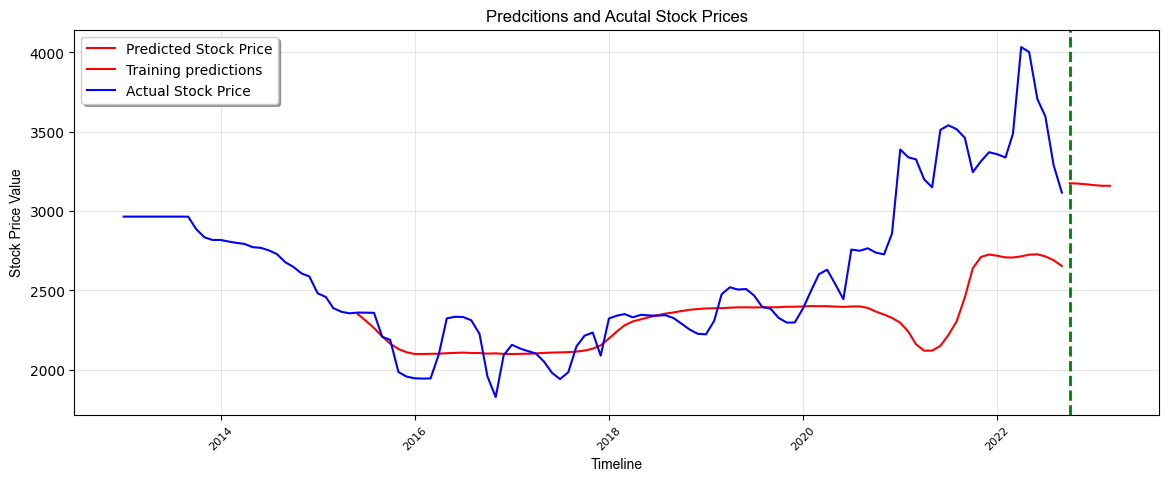

In [8]:
training_start= 2 * n_past + n_future -1
PREDICTIONS_FUTURE = pd.DataFrame(data_point_predicted_w_factor, columns=['predicted_forecast']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['predicted_training']).set_index(pd.Series(datelist_train[training_start:]))

dataset_train.index= datelist_train
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2013-01-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['predicted_forecast'], color='r', label='Predicted Stock Price')
# plt.plot(PREDICTIONS_FUTURE_.index, PREDICTIONS_FUTURE_['predicted_forecast'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[:].index, PREDICTION_TRAIN.loc[:]['predicted_training'], color='r', label='Training predictions')
plt.plot(dataset_train.loc[:].index, dataset_train.loc[:]['price'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()
